# Import Data

In [2]:
import pandas as pd

data = pd.read_csv("final_merged_300.csv", index_col=0)
data = data.drop(columns=["MP_diff(y)"])
len(data)

5250

# Deal with Null values

In [3]:
print(data.isna().sum())

TCAS_std         0
TCAS_mean        0
TCAS_close       0
TCAS_delta       0
TCAS_corr        0
TCBS_std         0
TCBS_mean        0
TCBS_close       0
TCBS_delta       0
TCBS_corr        0
ALPHA_std        0
ALPHA_mean       0
ALPHA_close      2
ALPHA_delta      4
ALPHA_corr      83
BETA_std         0
BETA_mean        0
BETA_close       3
BETA_delta       5
BETA_corr      173
ZETA_std         0
ZETA_mean        0
ZETA_close       3
ZETA_delta       7
ZETA_corr      212
WMP_std          0
WMP_delta        0
WMP_corr         0
AWS_std          0
AWS_mean         0
AWS_close        0
AWS_delta        0
AWS_corr         0
VOL_std          0
VOL_mean         0
VOL_close        0
VOL_delta        0
VOL_corr         0
GAP_std          0
GAP_mean         0
GAP_close        6
GAP_delta        6
GAP_corr       139
nUoD_std         0
nUoD_mean        0
nUoD_close       0
nUoD_delta       0
nUoD_corr        0
PSTD_std         0
PSTD_mean        0
PSTD_close       0
PSTD_delta       0
PSTD_corr   

In [4]:
for feat in list(data):
    if feat.split("_")[-1] in ["close", "mean"]:
        data = data[~data[feat].isna()] # drop absolute values

data.fillna(0, inplace=True) # fill delta and corr values with 0
len(data)

5243

# EDA

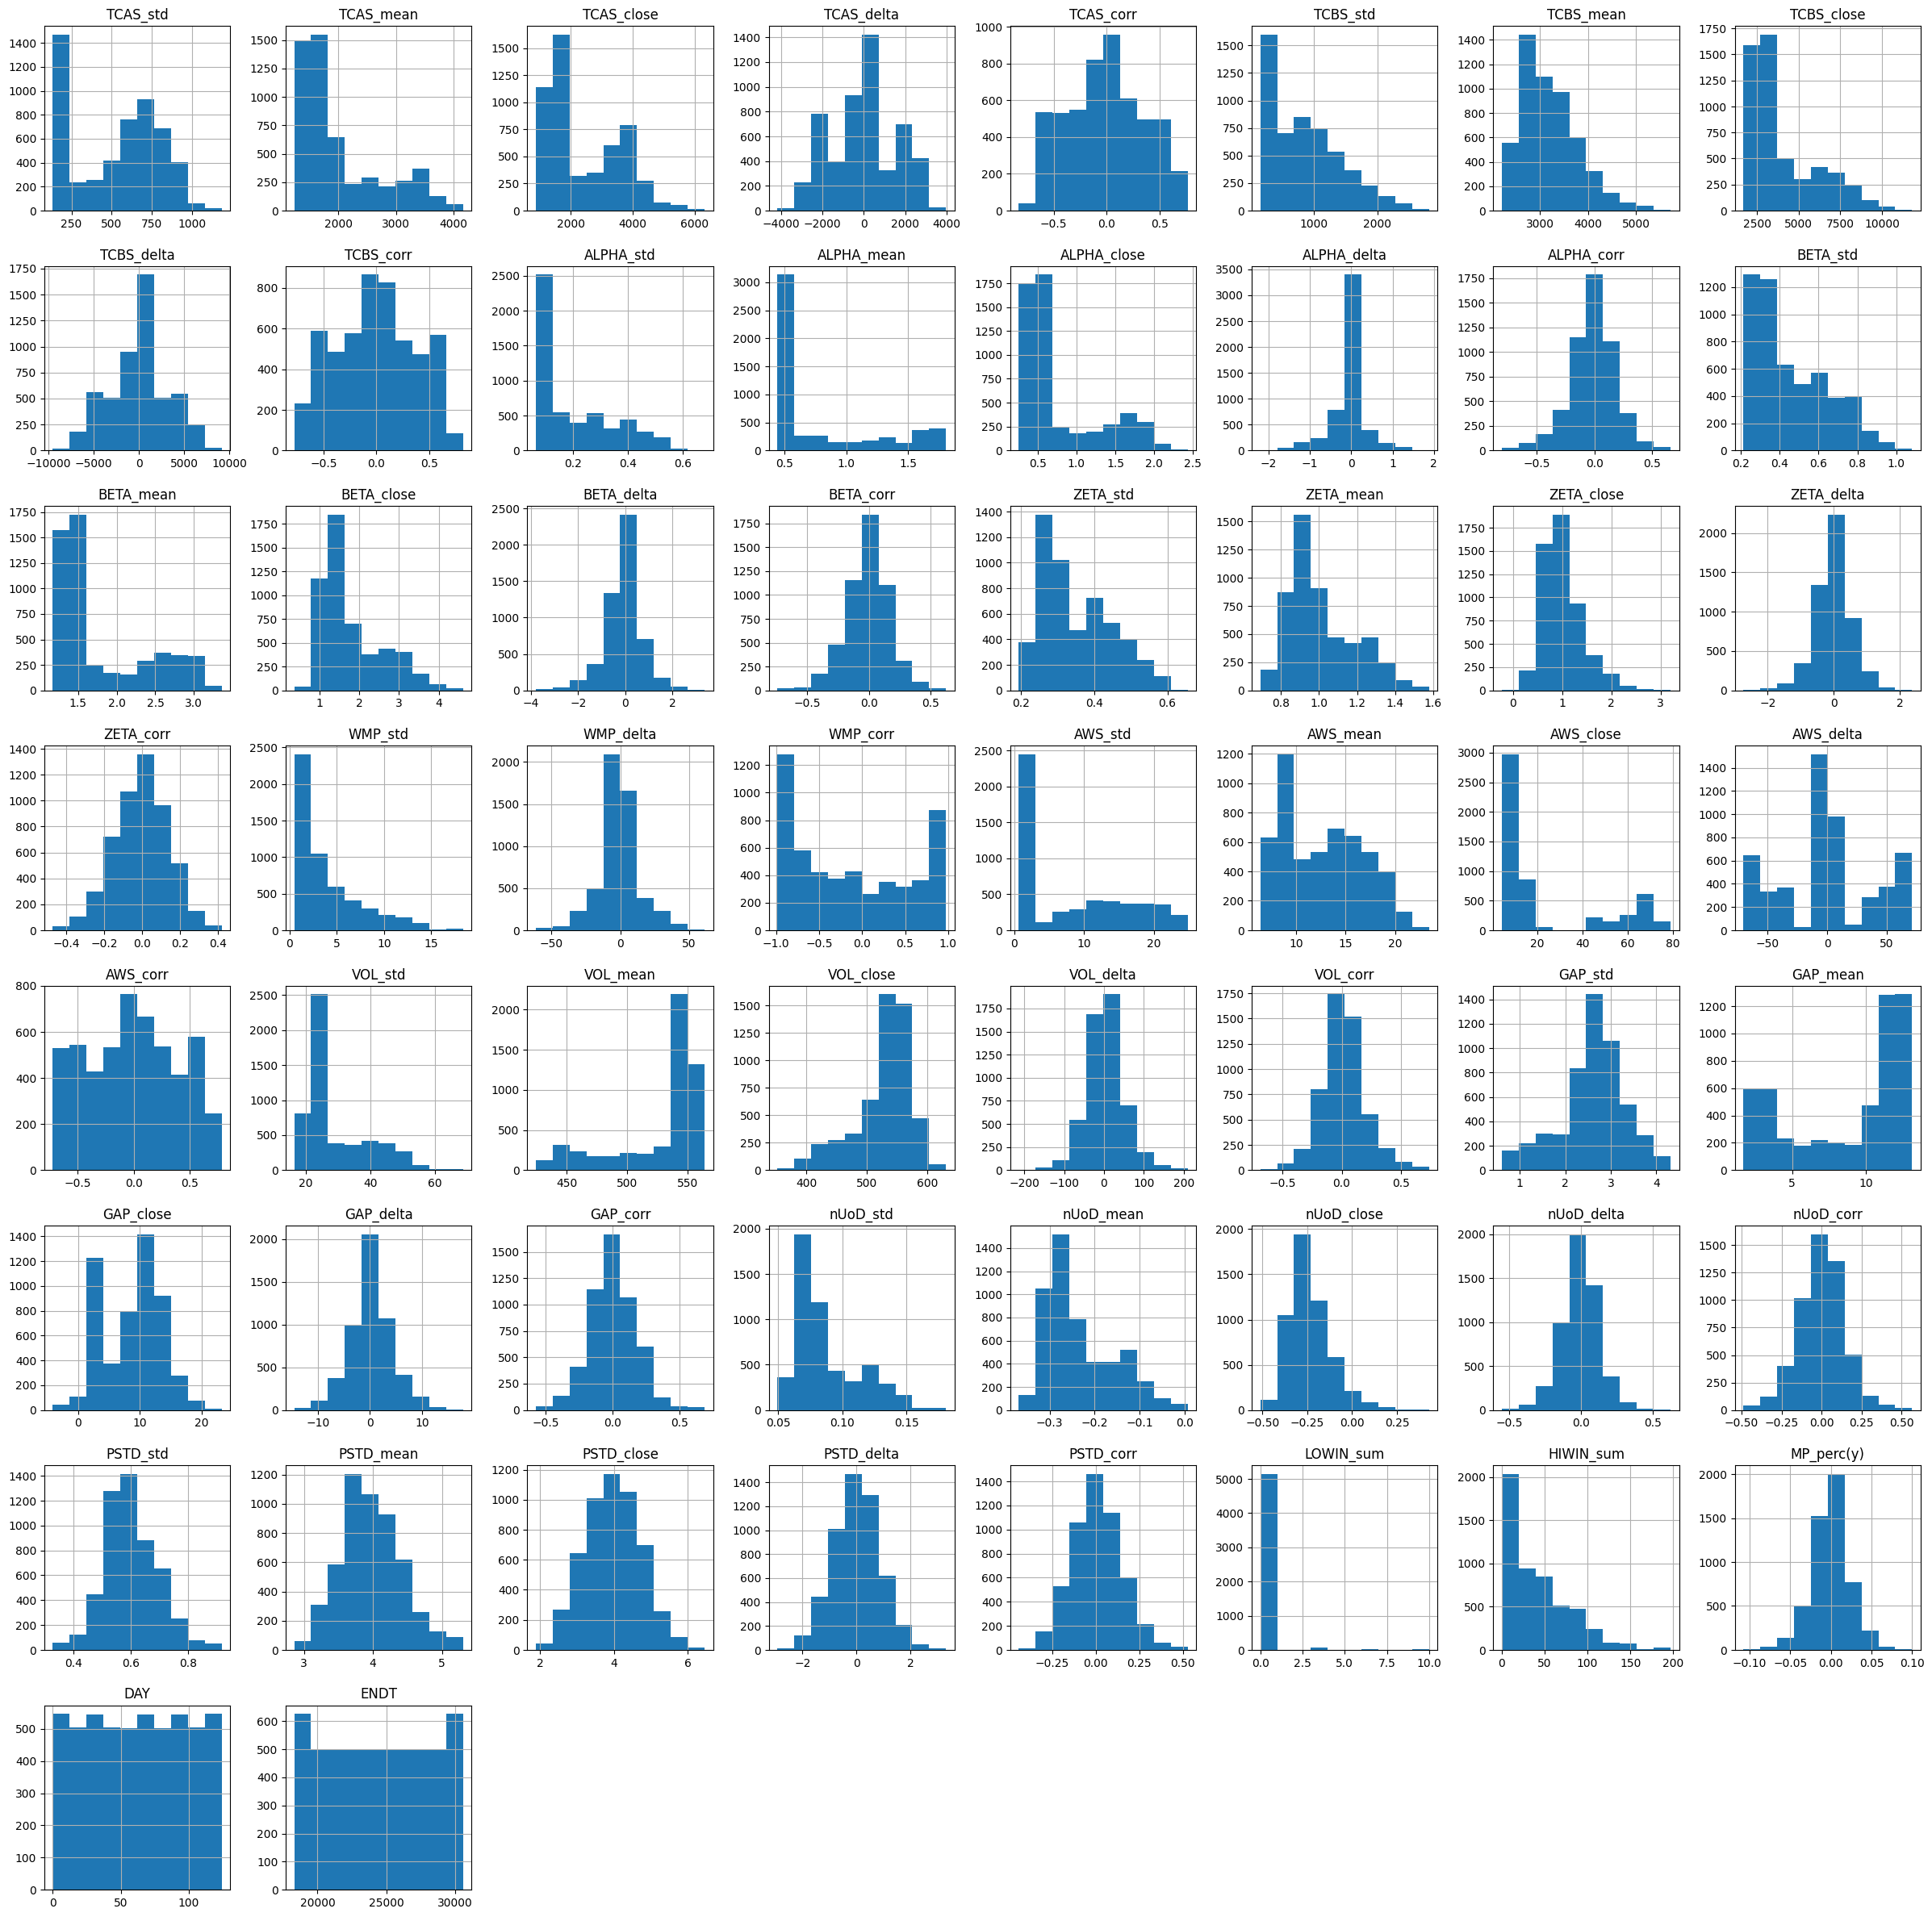

In [5]:
import matplotlib.pyplot as plt
data.hist(figsize=(30,30))
plt.show()

In [6]:
# scale features

x_features = list(data)
x_features.remove("MP_perc(y)")

# scale data between 0 and 1
for col in x_features:
    #data[col] = np.log(data[col] + data[col].min())
    data[col] = (data[col] - data[col].min()) / (data[col].max() - data[col].min())

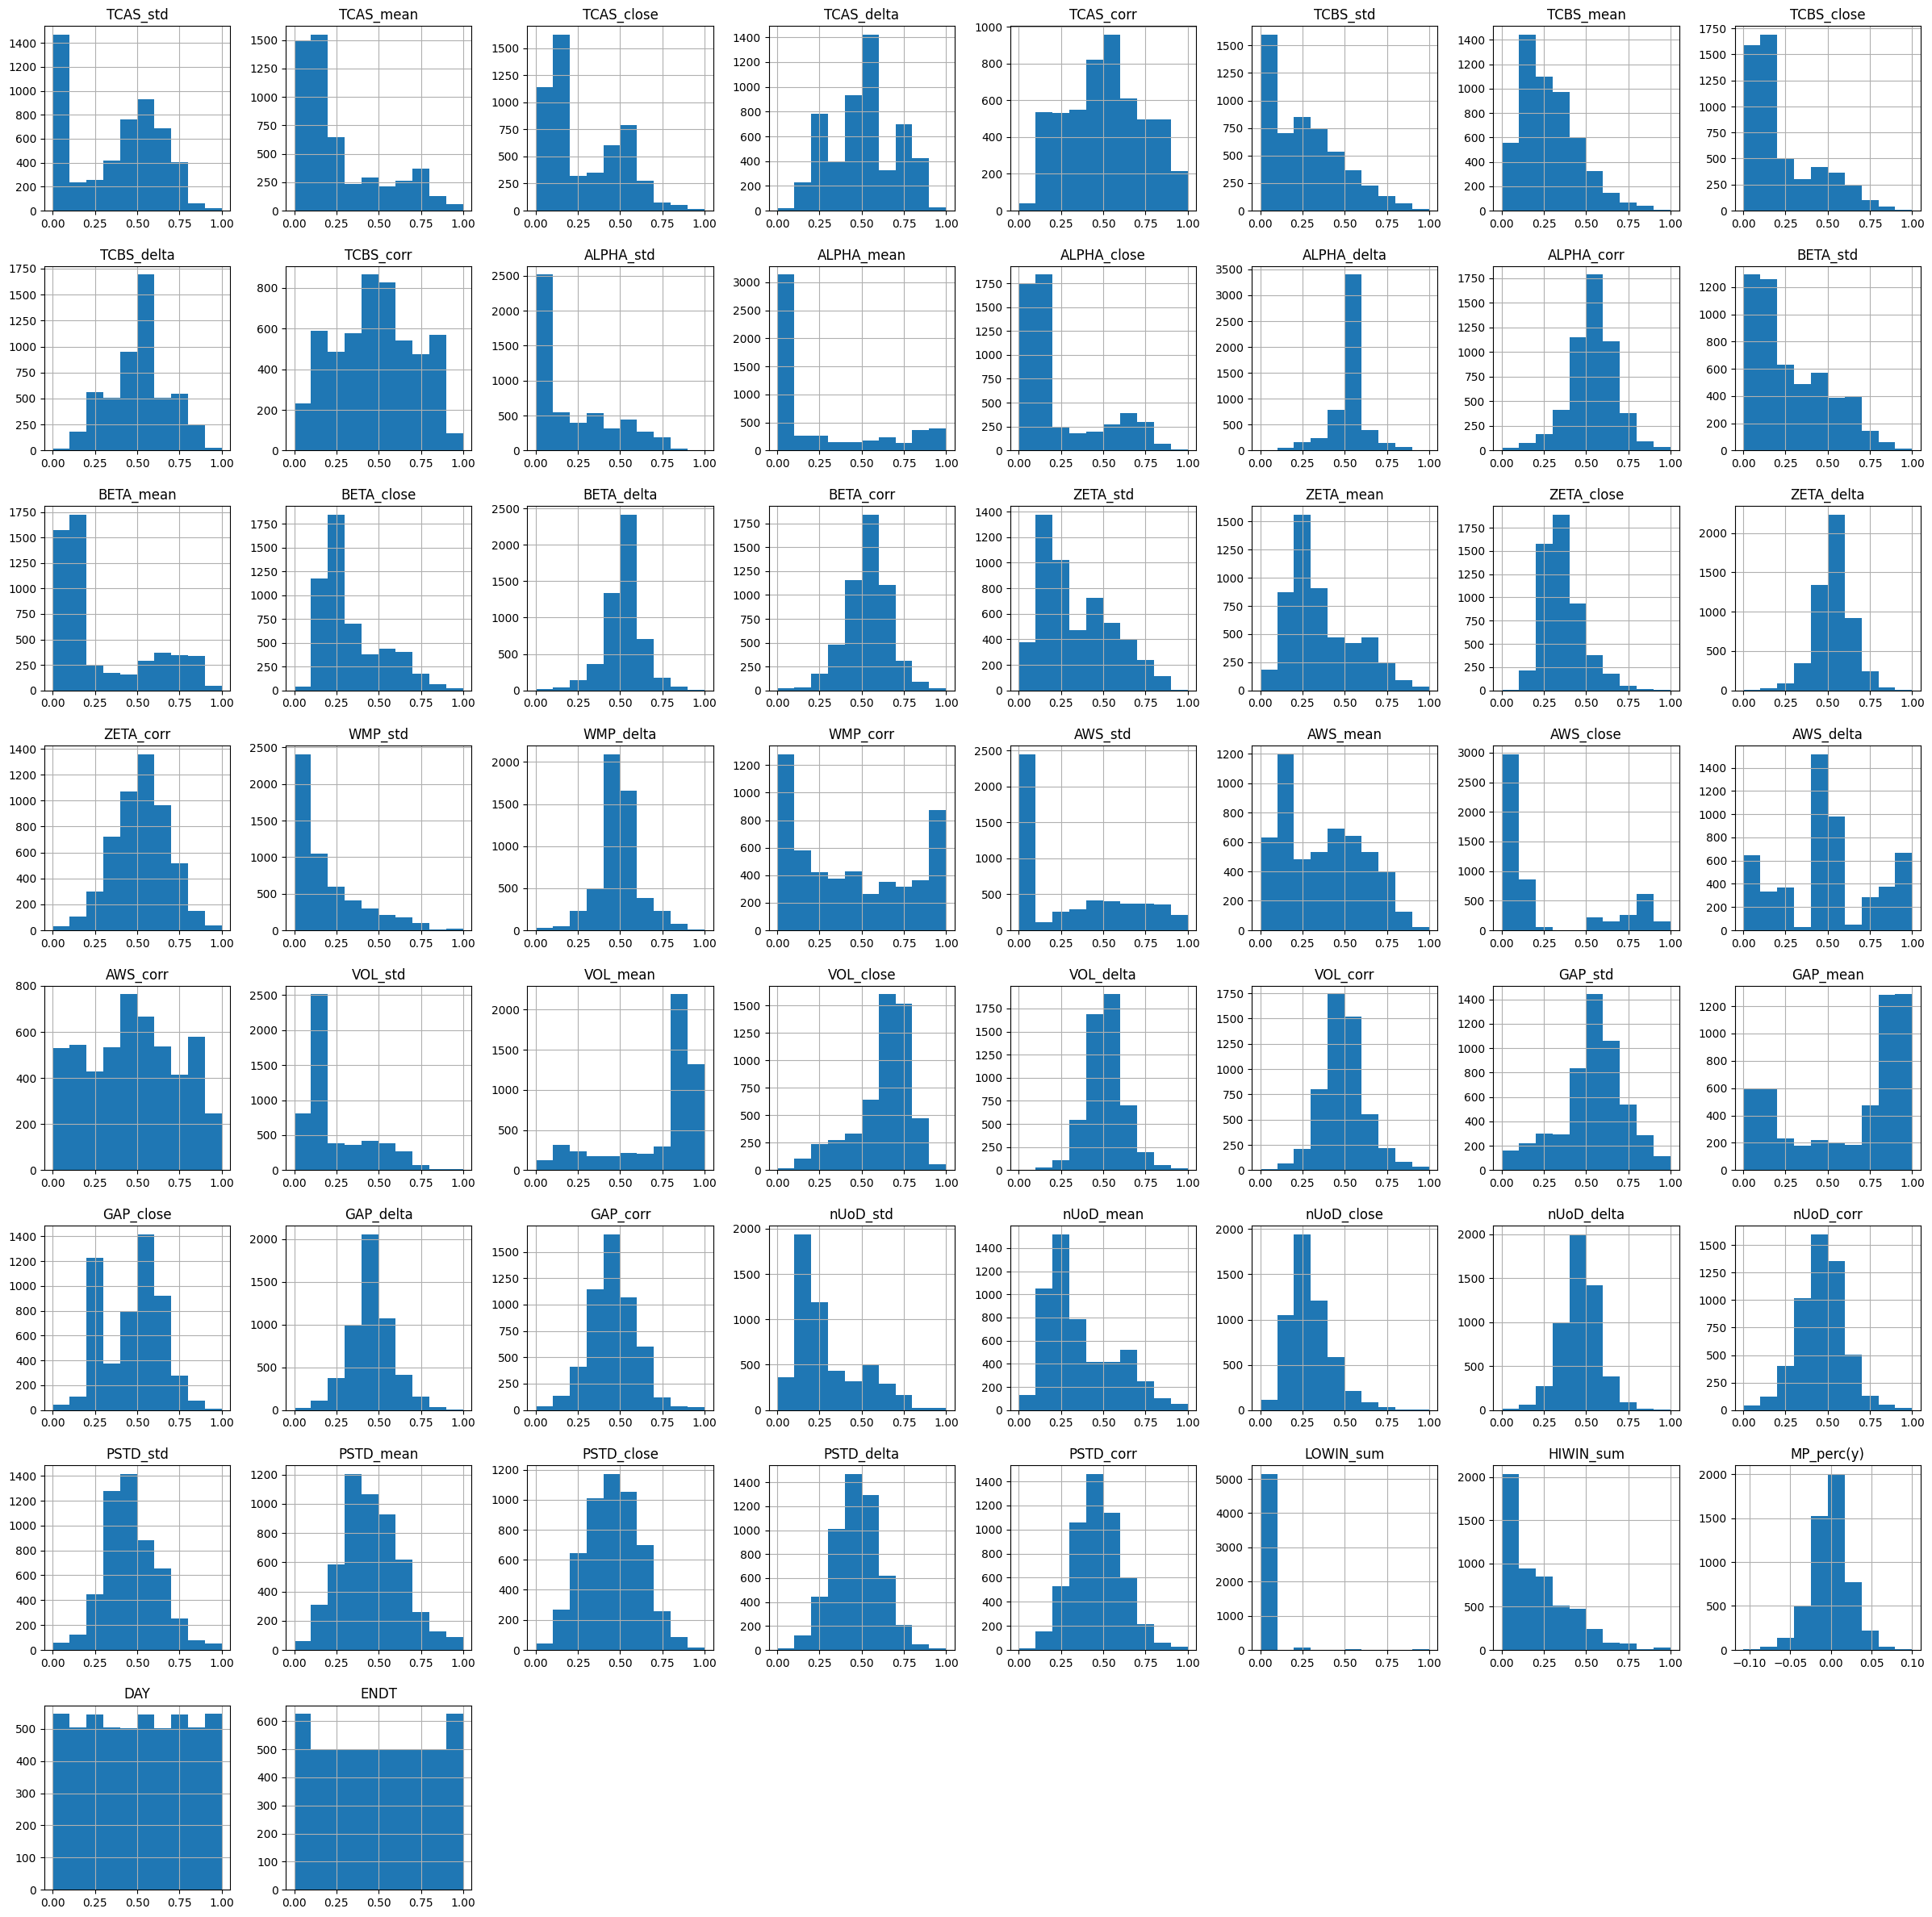

In [7]:
data.hist(figsize=(30,30))
plt.show()

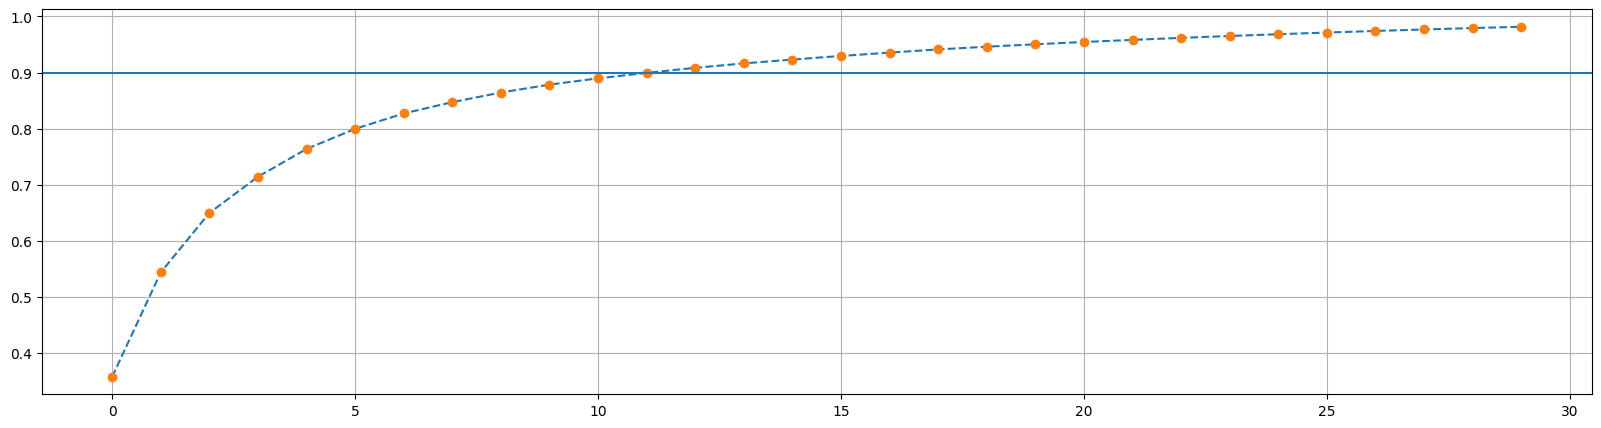

In [8]:
# apply pca
from sklearn.decomposition import PCA
import numpy as np

pca_features = x_features[:]
pca_features.remove("ENDT")
pca_features.remove("DAY")

pca = PCA(n_components=30)
pca_vectors = pca.fit_transform(data[pca_features])

plt.figure(figsize=(20,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), linestyle = "--")
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'o')
plt.axhline(0.9)
plt.grid()

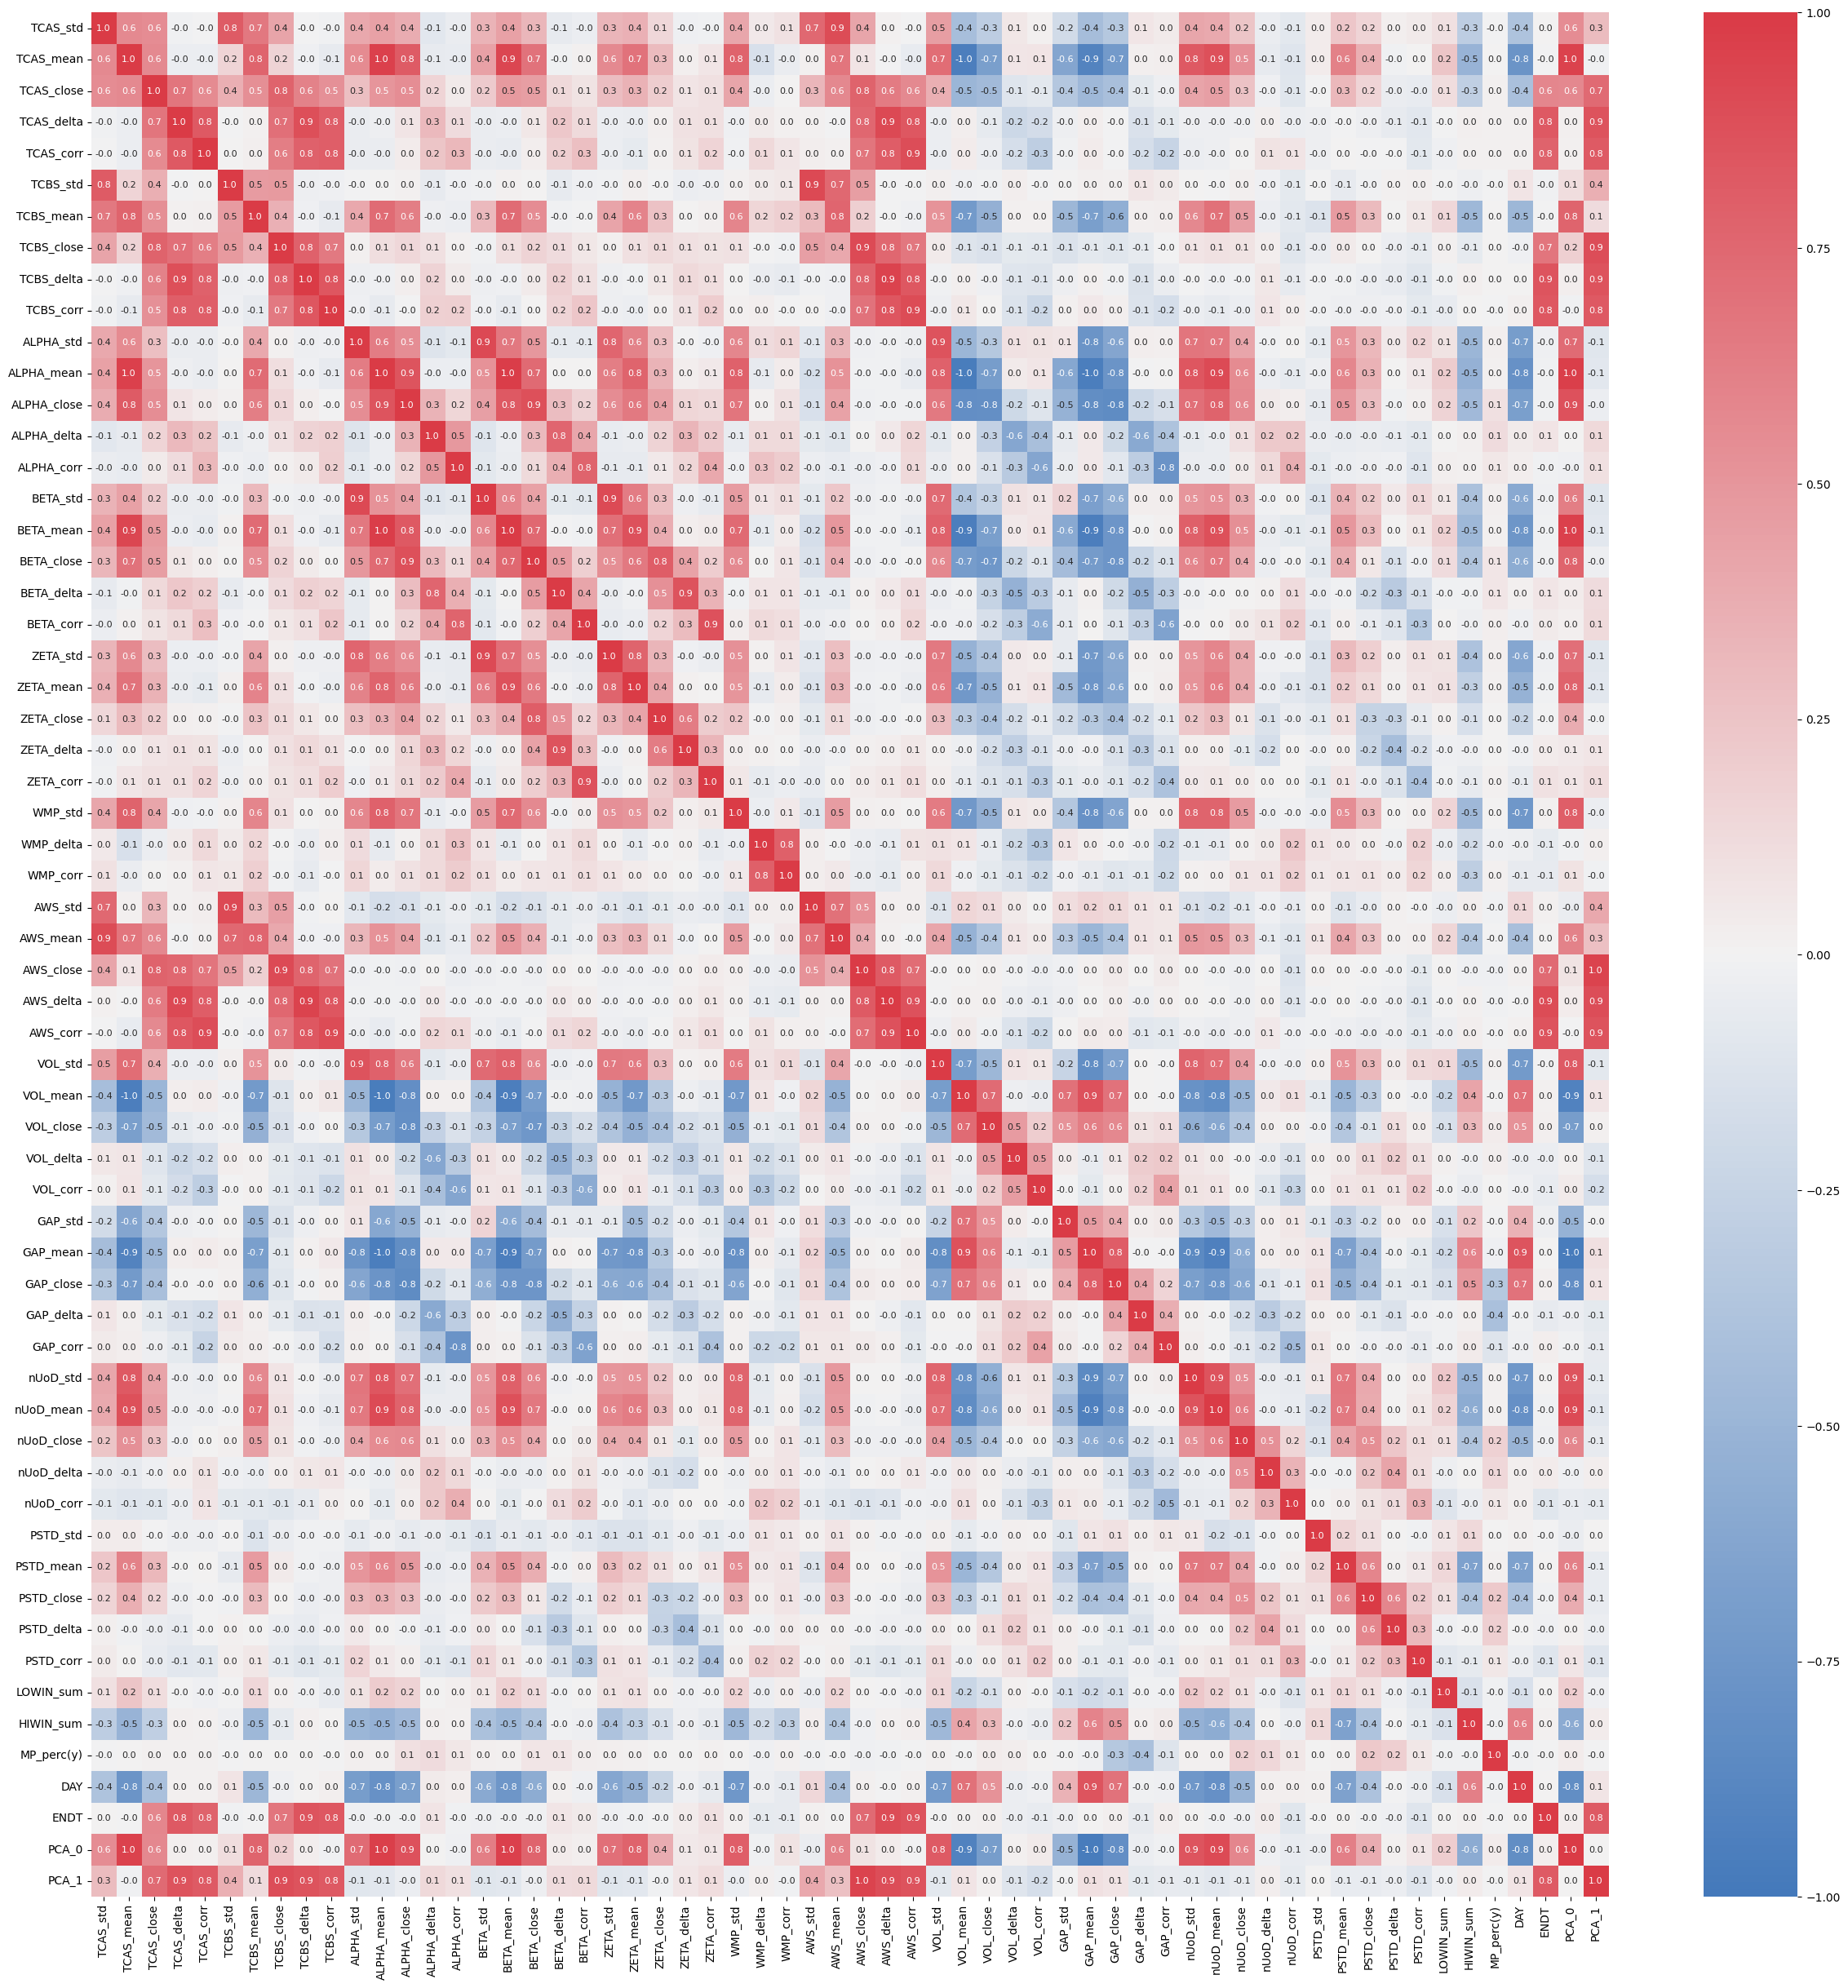

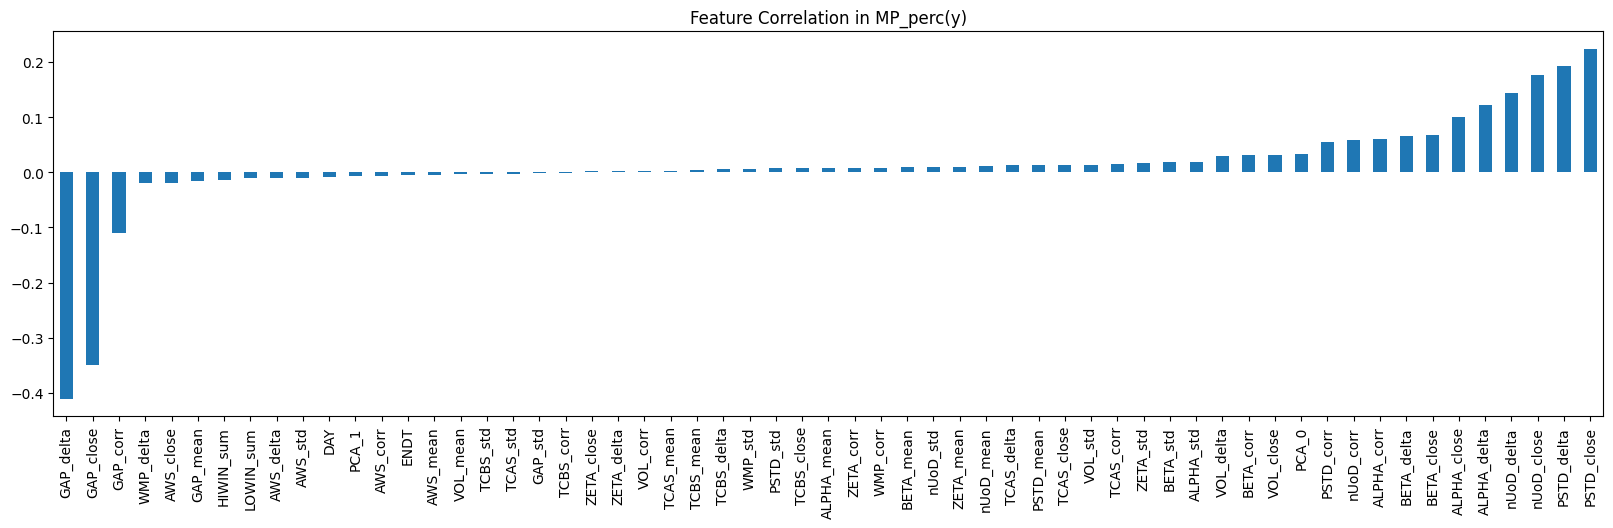

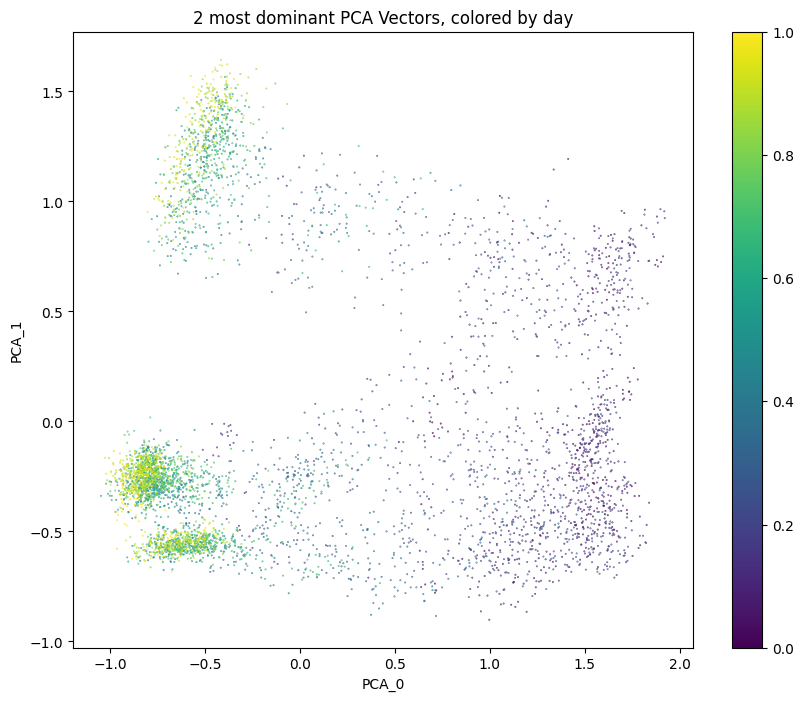

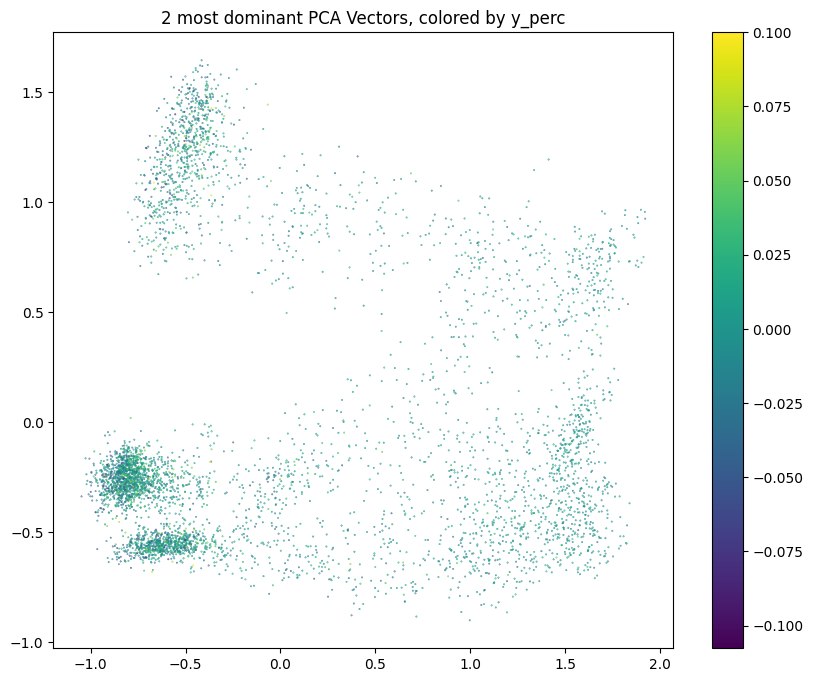

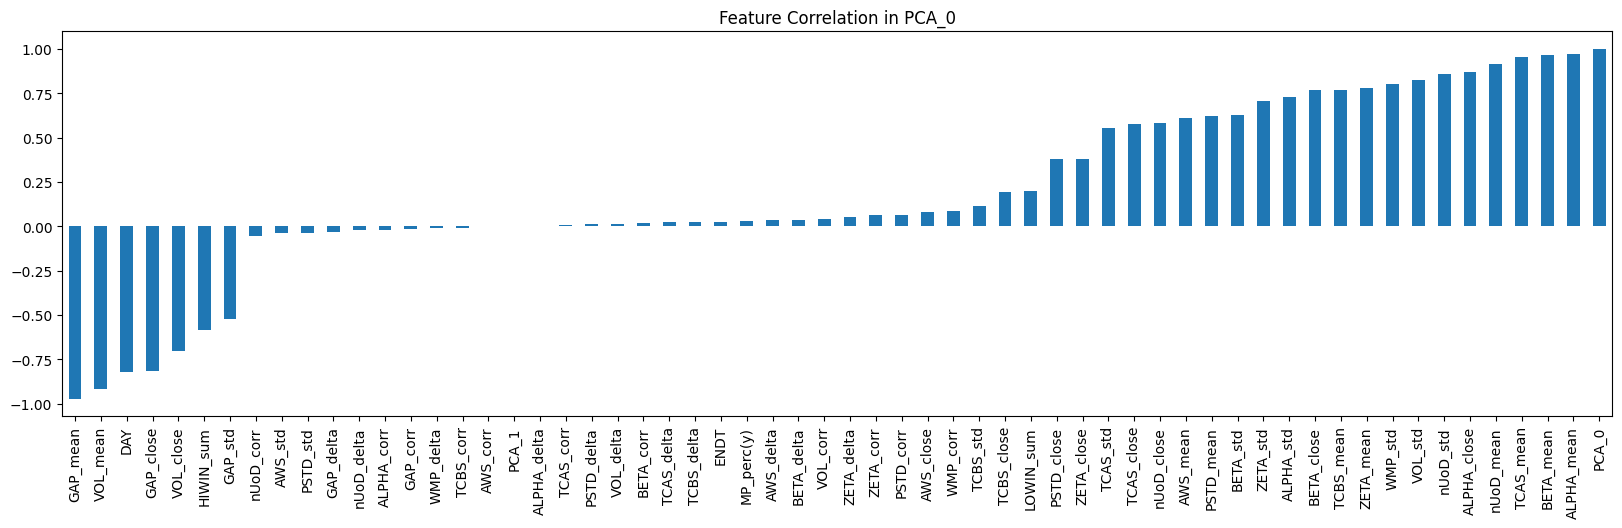

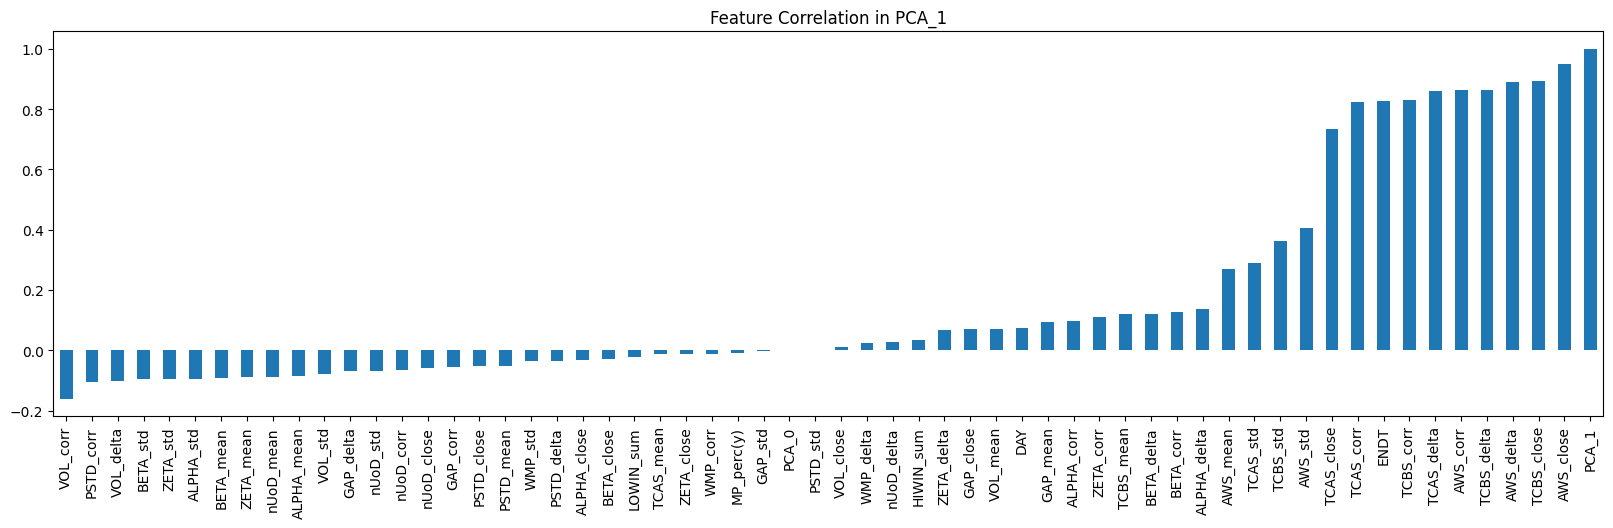

In [9]:
X = pca_vectors[:,:2]
import seaborn as sns

for i in range(X.shape[1]):
    data[f"PCA_{i}"] = X[:,i]

plt.figure(figsize=(30,30))
corr_map = data.corr()
cmap = sns.diverging_palette(250, 10, as_cmap=True)
sns.heatmap(corr_map, vmin=-1, vmax=1, cmap=cmap, center=0, annot=True, fmt=".1f", annot_kws={"size": 8})
plt.show()

corr_map[corr_map.index != "MP_perc(y)"]["MP_perc(y)"].sort_values().plot(kind = "bar", figsize=(20,5))
plt.title("Feature Correlation in MP_perc(y)")
plt.show()

plt.figure(figsize=(10,8))
plt.title("2 most dominant PCA Vectors, colored by day")
plt.scatter(X[:,0], X[:,1], c = data["DAY"].to_numpy(), s = 1/2**3)
plt.xlabel("PCA_0")
plt.ylabel("PCA_1")
plt.colorbar()
plt.show()
plt.figure(figsize=(10,8))
plt.title("2 most dominant PCA Vectors, colored by y_perc")
plt.scatter(X[:,0], X[:,1], c = data["MP_perc(y)"], s = 1/2**3)
plt.colorbar()
plt.show()

corr_map["PCA_0"].sort_values().plot(kind = "bar", figsize=(20,5))
plt.title("Feature Correlation in PCA_0")
plt.show()
corr_map["PCA_1"].sort_values().plot(kind = "bar", figsize=(20,5))
plt.title("Feature Correlation in PCA_1")
plt.show()

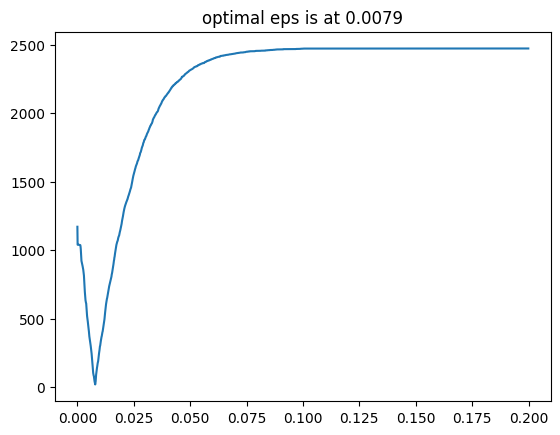

In [10]:
y_perc = data["MP_perc(y)"]

eps_vals = np.arange(0, 0.2, 0.0001)

def eps_y_bool(arr, eps):
    return np.std([np.sum(arr > eps),np.sum(arr < -eps), np.sum( (arr < eps) & (arr > -eps) )])
    
split_ratios = []
for eps in eps_vals:
    split_ratios.append(eps_y_bool(y_perc, eps))

optimal_eps = eps_vals[np.argmin(split_ratios)]
plt.title(f"optimal eps is at {optimal_eps}")
plt.plot(eps_vals, split_ratios)
plt.show()

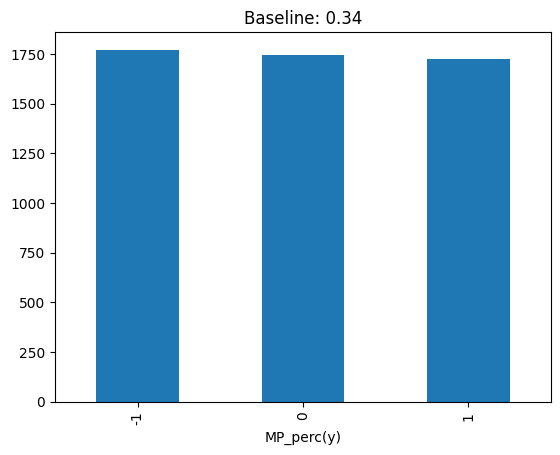

In [11]:
def gen_y_bool(y):
    if abs(y) < optimal_eps:
        return 0
    elif y > 0:
        return 1
    else:
        return -1
    
y_bool = y_perc.apply(gen_y_bool)
y_bool_splits = y_bool.value_counts()
y_bool_splits.plot(kind = "bar")
baseline = np.max(y_bool_splits) / len(data)
plt.title(f"Baseline: {baseline:.2f}")
plt.show()

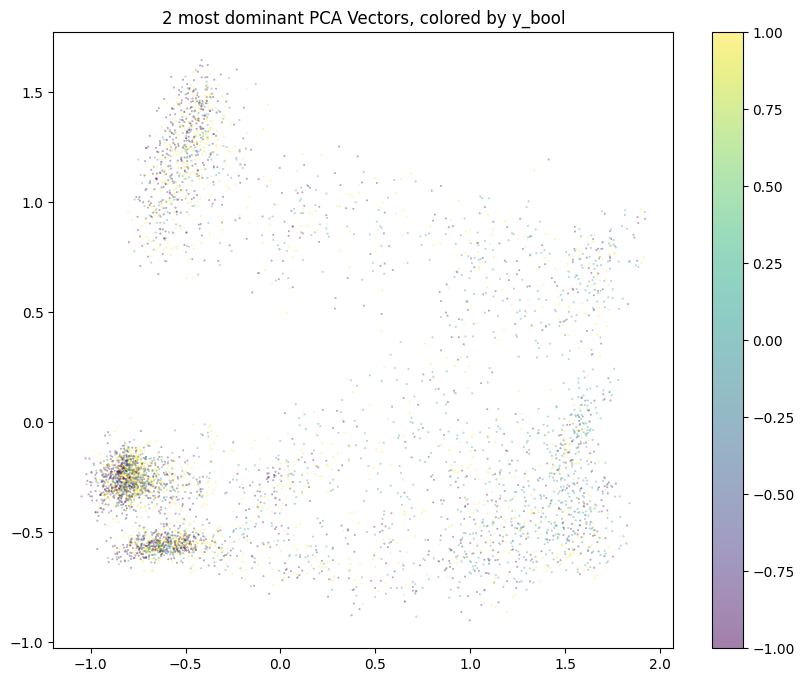

In [12]:
plt.figure(figsize=(10,8))
plt.title("2 most dominant PCA Vectors, colored by y_bool")
plt.scatter(X[:,0], X[:,1], c = y_bool.to_numpy(), s = 1/2**3, alpha=0.5)
plt.colorbar()
plt.show()

[ 0.11846033  0.10338072 -0.00511192 -0.07665079 -0.10392395 -0.10659316]


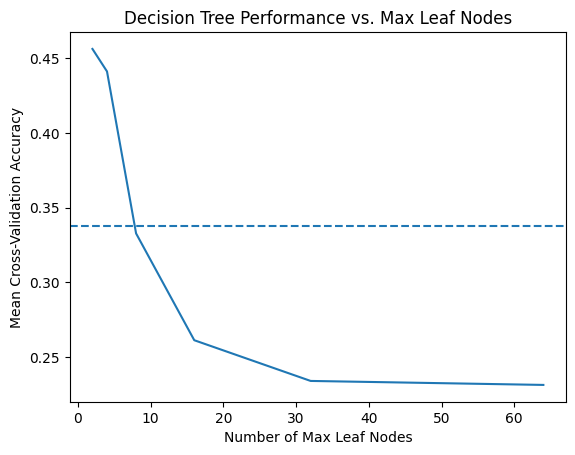

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score


cv_scores = []
tree_nodes = [2,4,8,16,32,64]

mask = y_bool != 0

for n in tree_nodes:
    clf = DecisionTreeClassifier(max_leaf_nodes=n)
    scores = cross_val_score(clf, data[x_features], y_bool, cv=5)  # Assuming you have data X and labels y
    cv_scores.append(scores.mean())

print(cv_scores - baseline)
plt.plot(tree_nodes, cv_scores)
plt.xlabel('Number of Max Leaf Nodes')
plt.ylabel('Mean Cross-Validation Accuracy')
plt.title('Decision Tree Performance vs. Max Leaf Nodes')
plt.axhline(baseline, linestyle = "--")
plt.show()

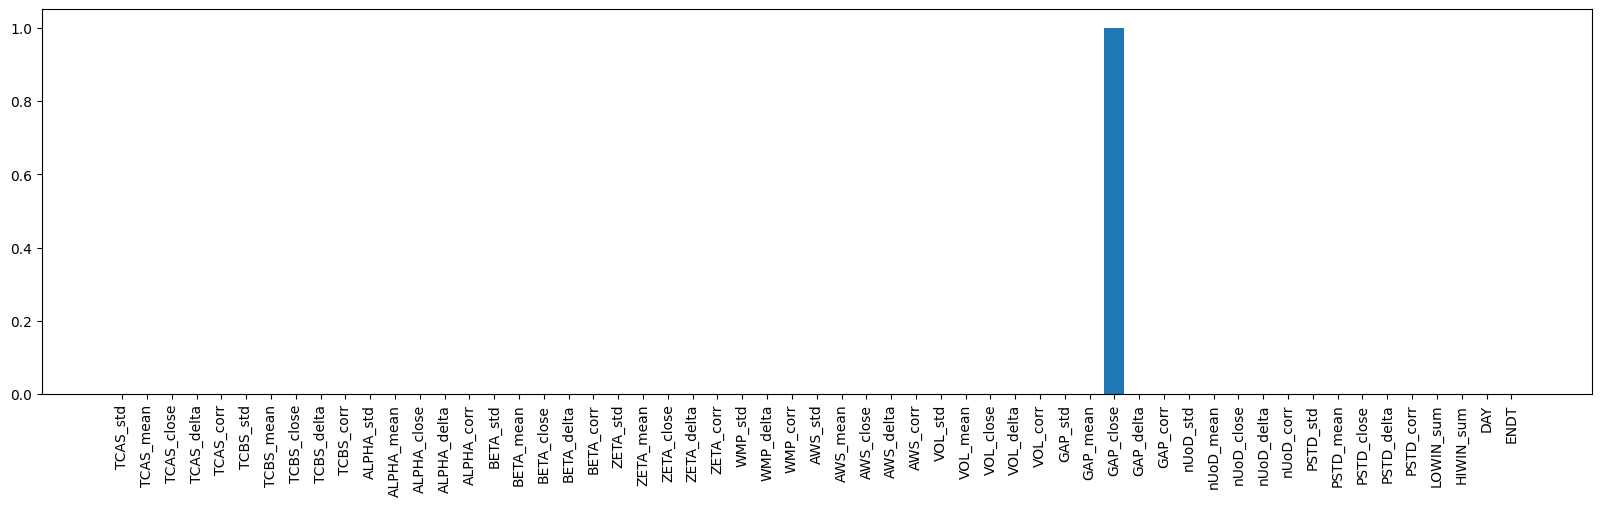

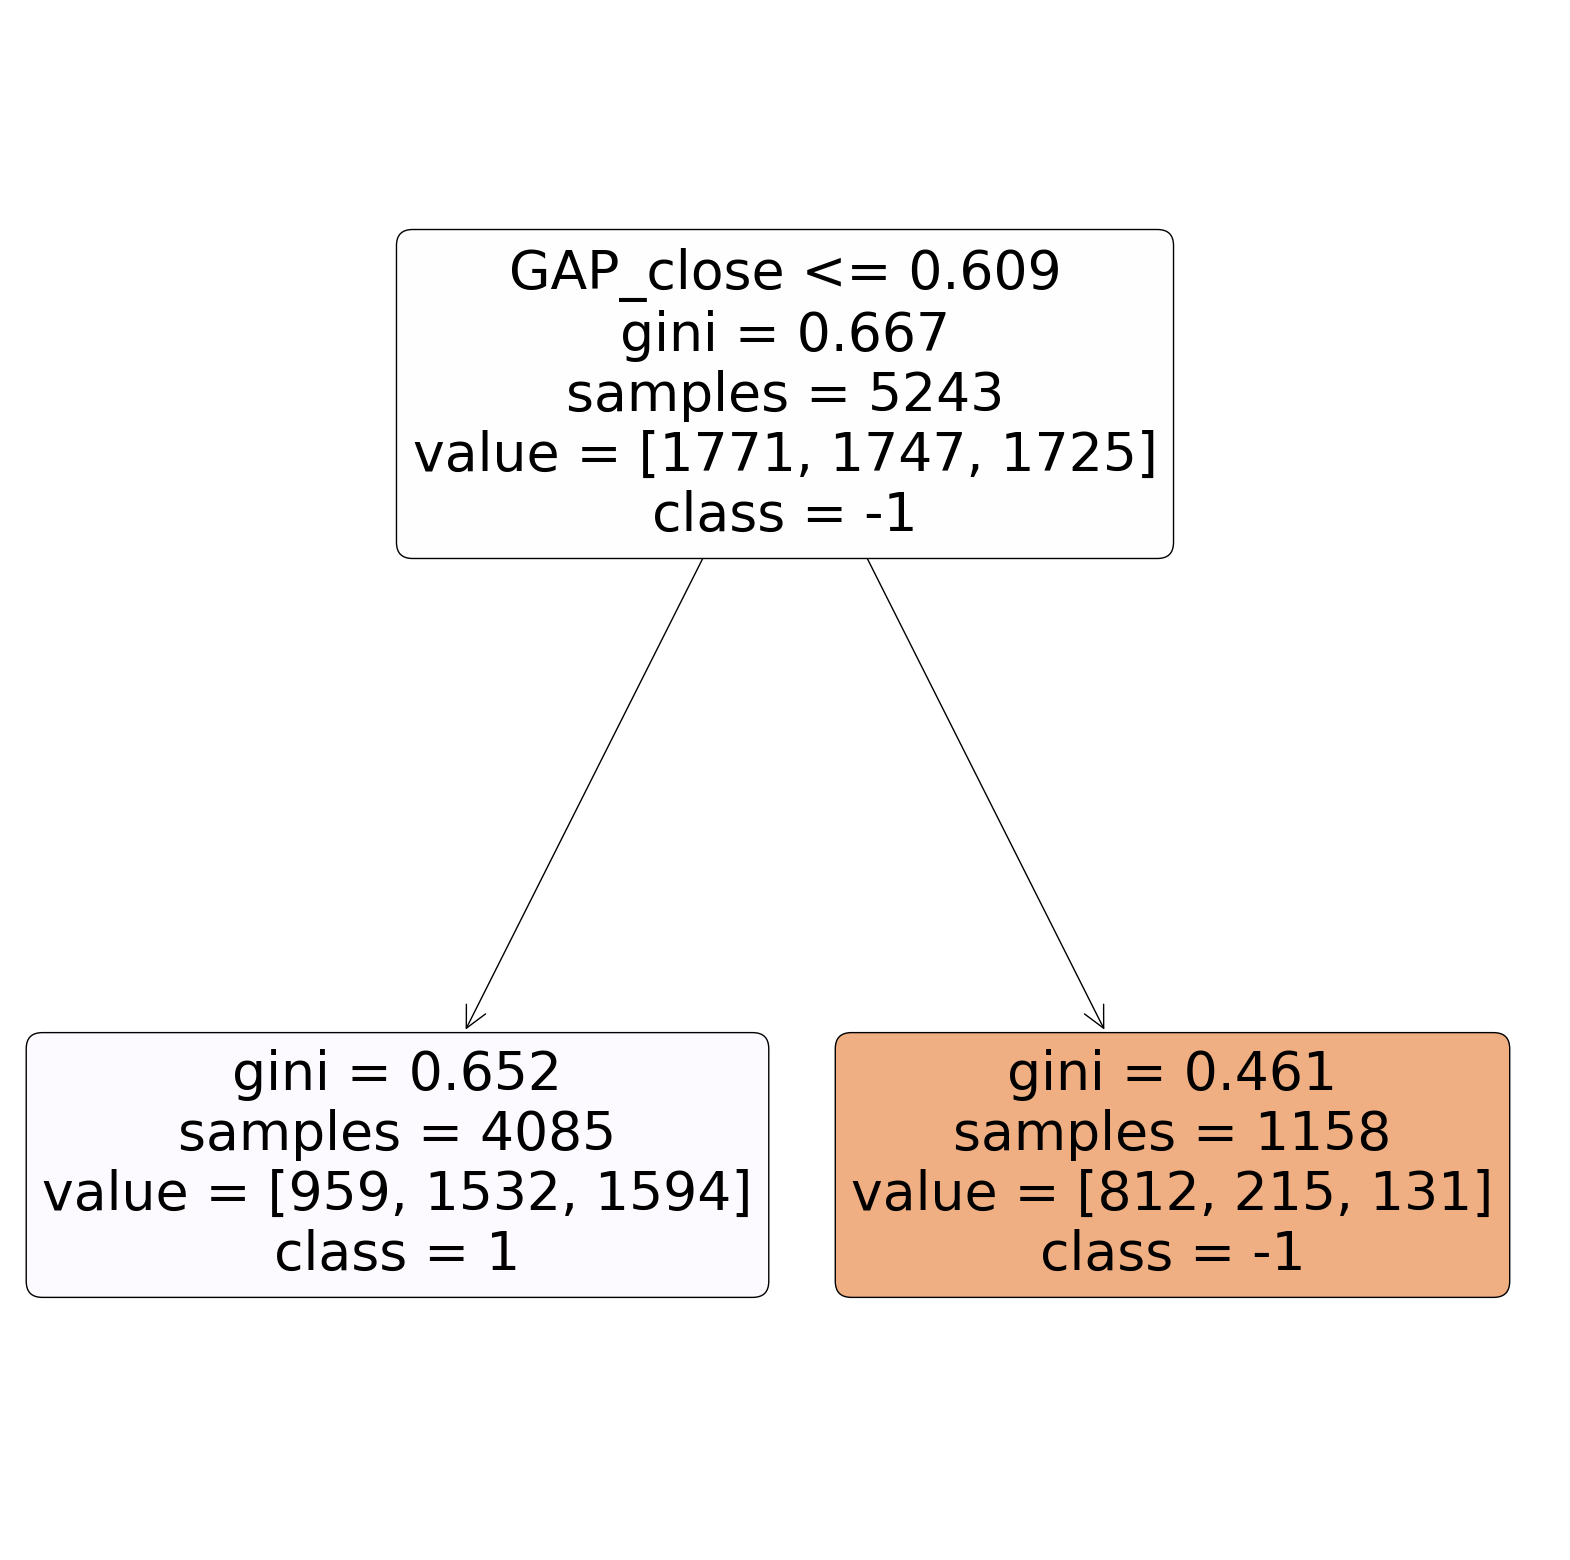

In [20]:
clf = DecisionTreeClassifier(max_leaf_nodes=2)
clf.fit(data[x_features],y_bool)

plt.figure(figsize=(20,5))
plt.bar(x_features, clf.feature_importances_)
plt.xticks(rotation = 90)
plt.show()

from sklearn.tree import plot_tree

plt.figure(figsize=(20,20))
plot_tree(clf, feature_names=x_features, class_names=[str(a) for a in clf.classes_], filled=True, rounded=True)
plt.show()

In [21]:
from sklearn.metrics import confusion_matrix

ypred = clf.predict(data[x_features])
ytrue = y_bool.to_numpy()
conf_matrix = confusion_matrix(ytrue, ypred, labels=clf.classes_)

for i, clas in enumerate(clf.classes_):
    print(f"Class {clas} Analysis...")
    
    print("Baseline =", np.mean(ytrue != clas))
    TP = conf_matrix[i, i]
    FP = np.sum(conf_matrix[:, i]) - TP
    FN = np.sum(conf_matrix[i, :]) - TP
    TN = np.sum(conf_matrix) - TP - FP - FN
    
    print("TP =", TP)
    print("FP =", FP)
    print("TN =", TN)
    print("FN =", FN)
    
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print("Precision =", precision)
    print("Recall =", recall)
    print("F1 Score =", f1)
    print("Accuracy - Baseline =", ((TP + TN) / (TP + FP + TN + FN)) - np.mean(ytrue != clas))
    print()


Class -1 Analysis...
Baseline = 0.6622162883845126
TP = 812
FP = 346
TN = 3126
FN = 959
Precision = 0.7012089810017271
Recall = 0.45849802371541504
F1 Score = 0.5544554455445544
Accuracy - Baseline = 0.08888041197787533

Class 0 Analysis...
Baseline = 0.6667938203318711
TP = 0
FP = 0
TN = 3496
FN = 1747
Precision = nan
Recall = 0.0
F1 Score = 0
Accuracy - Baseline = 0.0

Class 1 Analysis...
Baseline = 0.6709898912836163
TP = 1594
FP = 2491
TN = 1027
FN = 131
Precision = 0.3902080783353733
Recall = 0.9240579710144927
F1 Score = 0.5487091222030981
Accuracy - Baseline = -0.1710852565325196



C:\Users\wwden\AppData\Local\Temp\ipykernel_14328\3895514742.py:21: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP / (TP + FP)


In [16]:
from sklearn.svm import SVC

svc_model = SVC(kernel="linear")

scores = cross_val_score(svc_model, data[x_features], y_bool, cv=5)

scores

array([0.39466158, 0.40324118, 0.41658723, 0.47519084, 0.51240458])

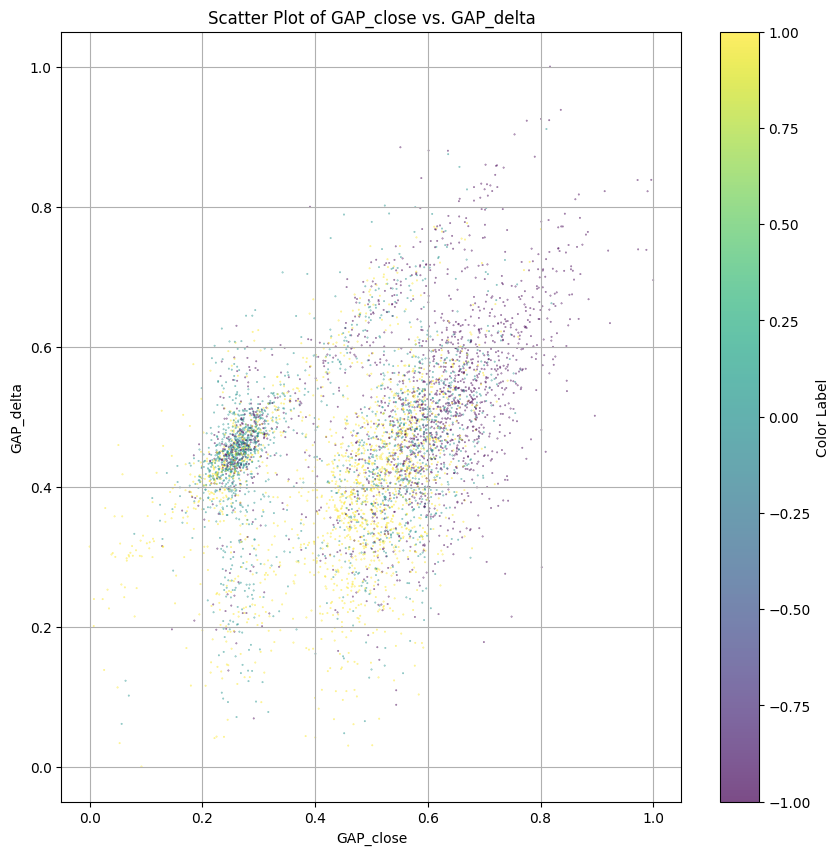

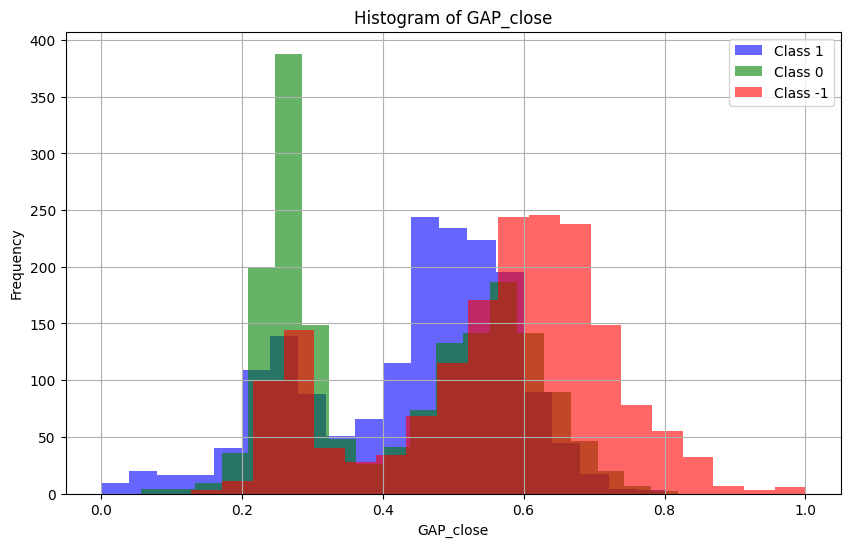

In [17]:
x_feat = "GAP_close" # most important features
y_feat = "GAP_delta" # 2nd most important / interesting feature

plt.figure(figsize=(10, 10))
plt.scatter(data[x_feat], data[y_feat], s=1/2**3, c=y_bool, alpha=0.7, marker='o')
plt.colorbar(label='Color Label')
plt.xlabel(x_feat)
plt.ylabel(y_feat)
plt.title(f'Scatter Plot of {x_feat} vs. {y_feat}')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(data[y_bool == 1][x_feat], bins=20, alpha=0.6, label="Class 1", color='blue')
plt.hist(data[y_bool == 0][x_feat], bins=20, alpha=0.6, label="Class 0", color='green')
plt.hist(data[y_bool == -1][x_feat], bins=20, alpha=0.6, label="Class -1", color='red')
plt.legend()
plt.xlabel(x_feat)
plt.ylabel('Frequency')
plt.title(f'Histogram of {x_feat}')
plt.grid(True)
plt.show()

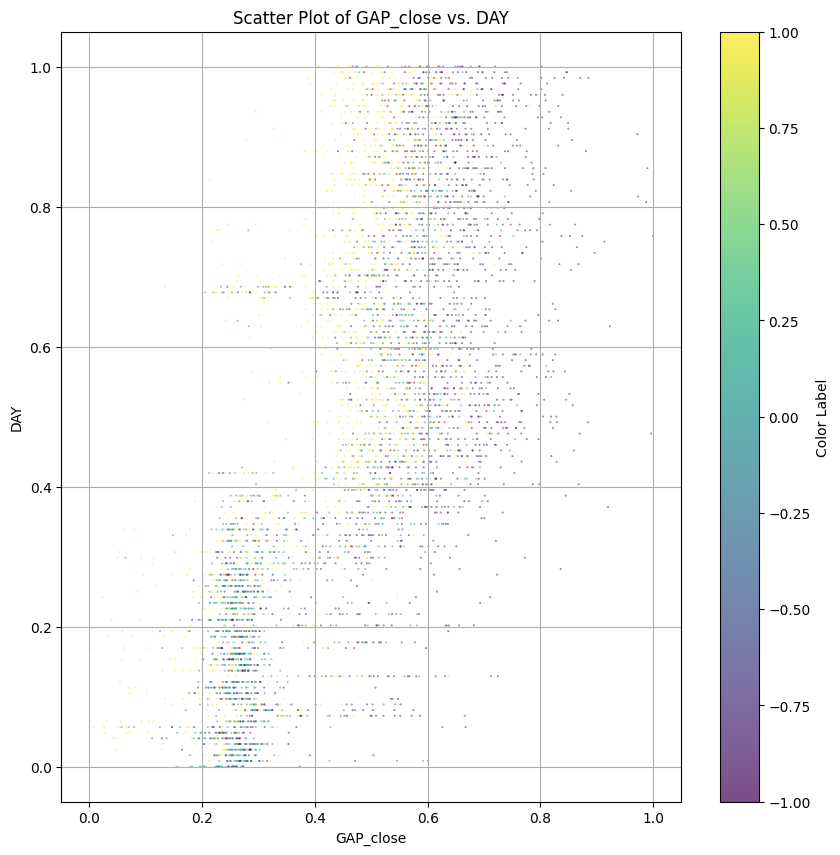

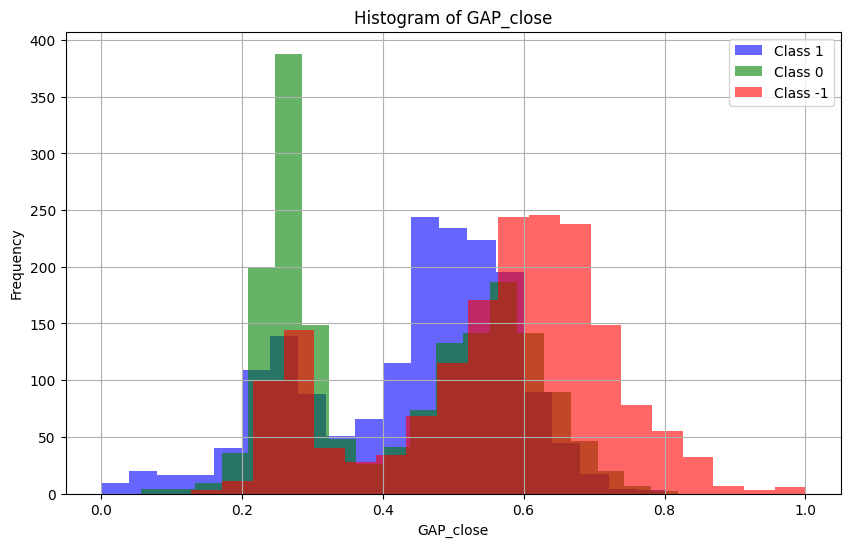

In [18]:
x_feat = "GAP_close" # most important features
y_feat = "DAY" # 2nd most important / interesting feature

plt.figure(figsize=(10, 10))
plt.scatter(data[x_feat], data[y_feat], s=1/2**3, c=y_bool, alpha=0.7, marker='o')
plt.colorbar(label='Color Label')
plt.xlabel(x_feat)
plt.ylabel(y_feat)
plt.title(f'Scatter Plot of {x_feat} vs. {y_feat}')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(data[y_bool == 1][x_feat], bins=20, alpha=0.6, label="Class 1", color='blue')
plt.hist(data[y_bool == 0][x_feat], bins=20, alpha=0.6, label="Class 0", color='green')
plt.hist(data[y_bool == -1][x_feat], bins=20, alpha=0.6, label="Class -1", color='red')
plt.legend()
plt.xlabel(x_feat)
plt.ylabel('Frequency')
plt.title(f'Histogram of {x_feat}')
plt.grid(True)
plt.show()